In [ ]:
%matplotlib inline

# Assuming we are in the notebooks directory, we need to move one up:
%cd ..

from __future__ import division

import os
import us
import requests

import pandas as pd
import geopandas as gpd

from utils.settings import (blocks_2010_shapefile_dir, acs5_shapefile_dir)

In [2]:
state = u'california'
state_fips = us.states.lookup(state).fips
state_fips

u'06'

In [ ]:
# try:
if True:
    print 'Attempting to load predicted population by block for:', state
#     df = gpd.read_file(blocks_geojson_filename)
# except IOError:
    print '\tNot found on disk...'
    print '\tDownloading and processing blocks and block groups for:', state
    # Open 2010 blocks for state (the population):
    print '\tOpening 2010 blocks shapefile for:', state
    blocks_2010_shapefile_name = blocks_2010_shapefile_dir + 'tabblock2010_' +\
        state_fips + '_pophu.shp'
    blocks_df = gpd.read_file(blocks_2010_shapefile_name)
    blocks_df['BLOCKID10'] = blocks_df['BLOCKID10'].apply(str)
    def get_group_GEOID(blockGEOID):
        return blockGEOID[0:-3]
    blocks_df['Block Group GEOID'] = blocks_df['BLOCKID10'].apply(get_group_GEOID)
    assert (blocks_df['Block Group GEOID'].apply(len)).unique() == [12]
    # The filename for the whole state with block groups (without population):
    print '\tOpening ACS5 block groups shapefile for:', state
    block_groups_shapefile_name = acs5_shapefile_dir + 'tl_' + year + '_' +\
        state_fips + '_bg.shp'
    block_groups_df = gpd.read_file(block_groups_shapefile_name)
    # We will add to this the population per block group from the API.
    # Check GEOIDs are of length 12 because they have to be by definition,
    # see: https://www.census.gov/geo/reference/geoidentifiers.html
    assert (block_groups_df['GEOID'].apply(len)).unique() == [12]

    
    
    
    print set(block_groups_df['GEOID'].unique()).symmetric_difference(set(
        blocks_df['Block Group GEOID'].unique()))
        # ['060378002043', '060379304011', u'060371370002', u'060371370001']

Attempting to load predicted population by block for: california
	Not found on disk...
	Opening 2010 blocks shapefile for: california


In [16]:
diff = list(set(block_groups_df['GEOID'].unique()).symmetric_difference(set(
         blocks_df['Block Group GEOID'].unique())))
len(diff)
diff

['060378002043', '060379304011', u'060371370002', u'060371370001']

In [17]:
for d in diff:
    if d in block_groups_df['GEOID'].values:
        print d
        print type(d)

060371370002
<type 'unicode'>
060371370001
<type 'unicode'>


In [18]:
# del lost_block_groups
#These are the block groups that get lost:
for i, d in enumerate(diff):
    if d in block_groups_df['GEOID'].values:

        print d
        d = str(d)
        print block_groups_df[block_groups_df['GEOID'].astype(unicode)== unicode(d)]
        try:
            lost_block_groups = pd.concat([lost_block_groups, block_groups_df[block_groups_df['GEOID'].astype(unicode)== unicode(d)]])
        except NameError:
            lost_block_groups = block_groups_df[block_groups_df['GEOID'].astype(str).str.contains(d)]
lost_block_groups.shape

060371370002
         ALAND  AWATER BLKGRPCE COUNTYFP FUNCSTAT         GEOID     INTPTLAT  \
15389  1836175       0        2      037        S  060371370002  +34.1669674   

           INTPTLON  MTFCC       NAMELSAD STATEFP TRACTCE  \
15389  -118.6423283  G5030  Block Group 2      06  137000   

                                                geometry  
15389  POLYGON ((-118.658618 34.171419, -118.658488 3...  
060371370001
        ALAND  AWATER BLKGRPCE COUNTYFP FUNCSTAT         GEOID     INTPTLAT  \
7976  1169619    4374        1      037        S  060371370001  +34.1674127   

          INTPTLON  MTFCC       NAMELSAD STATEFP TRACTCE  \
7976  -118.6298536  G5030  Block Group 1      06  137000   

                                               geometry  
7976  POLYGON ((-118.636332 34.163179, -118.636312 3...  


(4, 13)

In [19]:
lost_block_groups

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,STATEFP,TRACTCE,geometry
15389,1836175,0,2,037,S,060371370002,+34.1669674,-118.6423283,G5030,Block Group 2,06,137000,"POLYGON ((-118.658618 34.171419, -118.658488 3..."
7976,1169619,4374,1,037,S,060371370001,+34.1674127,-118.6298536,G5030,Block Group 1,06,137000,"POLYGON ((-118.636332 34.163179, -118.636312 3..."
15389,1836175,0,2,037,S,060371370002,+34.1669674,-118.6423283,G5030,Block Group 2,06,137000,"POLYGON ((-118.658618 34.171419, -118.658488 3..."
7976,1169619,4374,1,037,S,060371370001,+34.1674127,-118.6298536,G5030,Block Group 1,06,137000,"POLYGON ((-118.636332 34.163179, -118.636312 3..."


In [25]:
print len(set(block_groups_df['GEOID'].unique()).difference(set(blocks_df['Block Group GEOID'].unique())))


2


In [26]:
print len(set(blocks_df['Block Group GEOID'].unique()).difference(set(block_groups_df['GEOID'].unique())))

2


In [27]:
print blocks_df[blocks_df['Block Group GEOID'] == '040194705002']['POP10']


Series([], Name: POP10, dtype: int64)


In [28]:
print blocks_df[blocks_df['Block Group GEOID'] == '060371370001']['POP10']

Series([], Name: POP10, dtype: int64)


In [29]:
# Code to get the total estimated population from the census files:
api_population = 'B01003_001E'  # http://api.census.gov/data/2015/acs5/variables.html
# NB: this is not the same code in the shapefiles for each block from the 2010
# census, which instead uses 'POP10'.
# Get all the counties' IDs so we can d/l each county's population per
# block group:
def block_group_to_county_geoid(geoid):
    return geoid[2:5]
block_groups_df['County'] = block_groups_df['GEOID'].apply(block_group_to_county_geoid)
block_groups_for_state = acs5_population_dir + state + '.json'
try:
    print '\tAttempting to load ACS5 population for block groups by county for:', state
    with open(block_groups_for_state, 'r') as infile:
        population_df = pd.read_json(infile)
except IOError:
    print '\t\tNot found on disk...'
    counties = block_groups_df['County'].unique()
    for county in counties:
        print '\t\tDownloading block groups for county:', county
        url = 'http://api.census.gov/data/' + year + '/acs5?get=NAME,' +\
            api_population + '&for=block+group:*&in=state:' + \
            state_fips + '+county:' + county + '&key=' + apikey
        # Make a get request to get the population of each county per block
        # group:
        response = requests.get(url)
        try:
            data = response.json()
        except ValueError:  # includes simplejson.decoder.JSONDecodeError
            # This is what happens when the server times out etc.
            print 'Decoding JSON has failed. Server response:',\
                response.status_code
            exit()
        # Merge the df to get one huge df for the whole state which contains
        # all the group blocks and their populations:
        columns = data.pop(0) # columns as list and leaves data intact
        try:
            # Try appending to previous population_df:
            population_df = population_df.append(
                pd.DataFrame(data, columns=columns),
                ignore_index=True)
        except NameError:
            # There is no previous, so create it:
            population_df = pd.DataFrame(data, columns=columns)
    population_df.to_json(block_groups_for_state)
print '\tDone!'

	Attempting to load ACS5 population for block groups by county for: california
	Done!


In [30]:
def create_geoid(row):
    # GEOID Structure is defined as STATE + COUNTY + TRACT + BLOCK GROUP =
    # 2 + 3 + 6 + 1 = 12
    # see: https://www.census.gov/geo/reference/geoidentifiers.html
    STATE = str(row['state']).zfill(2)  # zero padding to conform to GEOID
    COUNTY = str(row['county']).zfill(3)
    TRACT = str(row['tract']).zfill(6)
    BLOCK_GROUP = str(row['block group'])
    assert len(STATE + COUNTY + TRACT + BLOCK_GROUP) == 12
    return STATE + COUNTY + TRACT + BLOCK_GROUP
population_df['GEOID'] = population_df.apply(create_geoid, axis=1)
    
    

In [31]:
block_groups_df.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,STATEFP,TRACTCE,geometry,County
0,12266417,680361,3,025,S,060259400003,+32.7424027,-114.6675664,G5030,Block Group 3,06,940000,"POLYGON ((-114.726531 32.718236, -114.726392 3...",025
1,59331725,0,2,025,S,060250108002,+32.7658550,-115.3923892,G5030,Block Group 2,06,010800,"POLYGON ((-115.430817 32.730903, -115.430817 3...",025
2,230656791,0,1,025,S,060250108001,+32.8363463,-115.3514134,G5030,Block Group 1,06,010800,"POLYGON ((-115.457835 32.908953, -115.457726 3...",025
3,1209336,0,3,025,S,060250111003,+32.7932442,-115.6903925,G5030,Block Group 3,06,011100,"POLYGON ((-115.701342 32.790854, -115.70091 32...",025
4,404606,0,2,073,S,060730100132,+32.5564082,-117.0507980,G5030,Block Group 2,06,010013,"POLYGON ((-117.054301 32.555424, -117.054296 3...",073


In [32]:
block_groups_df = block_groups_df.merge(population_df, on='GEOID')
assert block_groups_df['GEOID'].shape == population_df['GEOID'].shape
#     del population_df
# Get rid of other columns, we are just interested in below for each block
# group:
block_groups_df = block_groups_df.loc[:,['GEOID',api_population]]
# We need to calculate the proportion of the populalion of 2010 block group
# that a constituent 2010 block has:
# a. get the total population for each block group from 2010 and associate
# each 2010 block with its total:
blocks_df['POP10'] = pd.to_numeric(blocks_df['POP10'])
blocks_df = blocks_df.join(blocks_df.groupby('Block Group GEOID')[
                           'POP10'].sum(), on='Block Group GEOID',
                            rsuffix=' for 2010 Block Group')
blocks_df.rename(columns={'POP10 for 2010 Block Group':\
                          'Population for 2010 Block Group'}, inplace=True)

In [33]:
blocks_df.head()

,BLOCKCE,BLOCKID10,COUNTYFP10,HOUSING10,PARTFLG,POP10,STATEFP10,TRACTCE10,geometry,Block Group GEOID,Population for 2010 Block Group
0,2001,060014403362001,001,1,N,4,06,440336,"POLYGON ((-122.010627 37.582659, -122.010821 3...",060014403362,2305
1,2022,060014403362022,001,16,N,66,06,440336,"POLYGON ((-122.01992 37.580664, -122.019717 37...",060014403362,2305
2,1000,060014401001000,001,6,N,12,06,440100,"POLYGON ((-121.97565 37.640444, -121.97417 37....",060014401001,2310
3,1003,060014506011003,001,0,N,0,06,450601,"POLYGON ((-121.950215 37.661304, -121.950202 3...",060014506011,629
4,1057,060014351031057,001,5,N,13,06,435103,"POLYGON ((-121.969345 37.643885, -121.969286 3...",060014351031,2702


In [34]:
# b. get the ratio of block population to respective block group
# population:
def calculate_ratio(row):
    try:
        return row['POP10'] / row['Population for 2010 Block Group']
    except:
        return row['Population for 2010 Block Group']
blocks_df['Population Ratio'] = blocks_df.apply(calculate_ratio, axis=1)
# c. get the population for the 2015 ACS5 block groups and associate them
# with their respective blocks:
blocks_df = pd.merge(blocks_df, block_groups_df,
                     left_on = 'Block Group GEOID',
                     right_on = 'GEOID')
blocks_df.rename(columns={api_population:\
                    'Population for ' + year + ' Block Group'},
                 inplace=True)
assert (blocks_df['GEOID'] == blocks_df['Block Group GEOID']).all()
del blocks_df['GEOID']
blocks_df['Population for ' + year + ' Block Group'] =\
    pd.to_numeric(blocks_df['Population for ' + year + ' Block Group'])
assert block_groups_df[api_population].sum() > blocks_df['POP10'].sum()
# assert blocks_df['Population for 2010 Block Group'].sum() <\
    # blocks_df['Population for ' + year + ' Block Group'].sum()
#     del block_groups_df # we do not need this anymore
# d. calculate the predicted population for the block based on the above:
blocks_df[population] = blocks_df['Population Ratio'] *\
    blocks_df['Population for ' + year + ' Block Group']
# Calculate the centroids for each block required for clustering:
def get_x(p): return p.x
def get_y(p): return p.y
blocks_df['Centroid Longitude'] = blocks_df['geometry'].centroid.apply(get_x)
blocks_df['Centroid Latitude'] = blocks_df['geometry'].centroid.apply(get_y)
# Find which congressional district each block group for this state belongs
#  to. This is done using the block assignments files downloaded from:
#  https://www.census.gov/geo/maps-data/data/baf.html
# print '\tCalculating congressional districts for:', state
block_assignments_df = pd.read_csv(block_assignments_dir +\
    'National_CD115.txt', dtype={"BLOCKID": str, "CD115": str})
block_assignments_df.rename(columns={'BLOCKID': 'GEOID'}, inplace=True)
blocks_df.rename(columns={'BLOCKID10': 'GEOID'}, inplace=True)
blocks_df = blocks_df.merge(block_assignments_df, how='left',
    indicator=True)
assert blocks_df['_merge'].unique() == ['both']
del blocks_df['_merge']
del block_assignments_df
# We are done now, check that columns are what we expect before we remove
# useless ones:
assert list(blocks_df) ==\
    [u'BLOCKCE', 'GEOID', u'COUNTYFP10', u'HOUSING10', u'PARTFLG', u'POP10',
     u'STATEFP10', u'TRACTCE10', 'geometry', 'Block Group GEOID',
     'Population for 2010 Block Group', 'Population Ratio',
     'Population for 2015 Block Group', 'Predicted 2015 Population',
     'Centroid Longitude', 'Centroid Latitude', 'CD115']

In [35]:
blocks_df.head()

,BLOCKCE,GEOID,COUNTYFP10,HOUSING10,PARTFLG,POP10,STATEFP10,TRACTCE10,geometry,Block Group GEOID,Population for 2010 Block Group,Population Ratio,Population for 2015 Block Group,Predicted 2015 Population,Centroid Longitude,Centroid Latitude,CD115
0,2001,060014403362001,001,1,N,4,06,440336,"POLYGON ((-122.010627 37.582659, -122.010821 3...",060014403362,2305,0.001735,2547,4.419957,-122.009388,37.582305,15
1,2022,060014403362022,001,16,N,66,06,440336,"POLYGON ((-122.01992 37.580664, -122.019717 37...",060014403362,2305,0.028633,2547,72.929284,-122.019607,37.579861,15
2,2016,060014403362016,001,31,N,83,06,440336,"POLYGON ((-122.020727 37.575511, -122.020871 3...",060014403362,2305,0.036009,2547,91.714100,-122.021492,37.576608,15
3,2000,060014403362000,001,0,N,0,06,440336,"POLYGON ((-122.009107 37.58342, -122.008322 37...",060014403362,2305,0.000000,2547,0.000000,-122.007805,37.582754,15
4,2004,060014403362004,001,23,N,63,06,440336,"POLYGON ((-122.015701 37.584183, -122.015746 3...",060014403362,2305,0.027332,2547,69.614317,-122.016318,37.583568,15


In [36]:
lost_block_groups.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,STATEFP,TRACTCE,geometry
15389,1836175,0,2,037,S,060371370002,+34.1669674,-118.6423283,G5030,Block Group 2,06,137000,"POLYGON ((-118.658618 34.171419, -118.658488 3..."
7976,1169619,4374,1,037,S,060371370001,+34.1674127,-118.6298536,G5030,Block Group 1,06,137000,"POLYGON ((-118.636332 34.163179, -118.636312 3..."
15389,1836175,0,2,037,S,060371370002,+34.1669674,-118.6423283,G5030,Block Group 2,06,137000,"POLYGON ((-118.658618 34.171419, -118.658488 3..."
7976,1169619,4374,1,037,S,060371370001,+34.1674127,-118.6298536,G5030,Block Group 1,06,137000,"POLYGON ((-118.636332 34.163179, -118.636312 3..."


In [37]:
# Get rid of colums we do not need:
blocks_df = blocks_df.loc[:,['GEOID', 'CD115', 'geometry',
                                 'Predicted 2015 Population',
                                 'Centroid Longitude', 'Centroid Latitude']]

In [38]:
blocks_df.head()

,GEOID,CD115,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude
0,060014403362001,15,"POLYGON ((-122.010627 37.582659, -122.010821 3...",4.419957,-122.009388,37.582305
1,060014403362022,15,"POLYGON ((-122.01992 37.580664, -122.019717 37...",72.929284,-122.019607,37.579861
2,060014403362016,15,"POLYGON ((-122.020727 37.575511, -122.020871 3...",91.714100,-122.021492,37.576608
3,060014403362000,15,"POLYGON ((-122.009107 37.58342, -122.008322 37...",0.000000,-122.007805,37.582754
4,060014403362004,15,"POLYGON ((-122.015701 37.584183, -122.015746 3...",69.614317,-122.016318,37.583568


In [39]:
# Give columns better names:
blocks_df.rename(columns={'CD115': 'Congressional District',
                          'Centroid Longitude': 'Centroid Longitude',
                          'Centroid Latitude': 'Centroid Latitude'},
                  inplace=True)
blocks_df['Congressional District'] = blocks_df['Congressional District'].apply(str)
blocks_df['Centroid Longitude'] = blocks_df['Centroid Longitude'].apply(float)
blocks_df['Centroid Latitude'] = blocks_df['Centroid Latitude'].apply(float)
blocks_df['Predicted 2015 Population'] = blocks_df['Predicted 2015 Population'].apply(float)
# We are finally done, save the file!
print 'Saving file...'
blocks_df = gpd.GeoDataFrame(blocks_df)
with open(blocks_geojson_filename, 'w') as outfile:
    outfile.write(blocks_df.to_json())
# In the rest of this code the block-wise dataframe with predicted
# populations is called just df:
df = blocks_df
del blocks_df
print 'Done!'

Saving file...
Done!


In [40]:
population_df.head()
lost_block_groups = lost_block_groups.merge(population_df, on='GEOID')

In [41]:
lost_block_groups.head()
lost_block_groups['Centroid Longitude'] = lost_block_groups['geometry'].centroid.apply(get_x)
    
lost_block_groups['Centroid Latitude'] = lost_block_groups['geometry'].centroid.apply(get_y)

In [42]:
lost_block_groups.rename(columns={'B01003_001E': 'Predicted 2015 Population'}, inplace=True)

lost_block_groups = lost_block_groups[['GEOID', 'geometry', 'Predicted 2015 Population', 'Centroid Longitude', 'Centroid Latitude']]
lost_block_groups.head()


,GEOID,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude
0,060371370002,"POLYGON ((-118.658618 34.171419, -118.658488 3...",2972,-118.642328,34.166967
1,060371370002,"POLYGON ((-118.658618 34.171419, -118.658488 3...",2972,-118.642328,34.166967
2,060371370001,"POLYGON ((-118.636332 34.163179, -118.636312 3...",1825,-118.628709,34.167565
3,060371370001,"POLYGON ((-118.636332 34.163179, -118.636312 3...",1825,-118.628709,34.167565


In [43]:
df.tail()

,GEOID,Congressional District,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude
710080,061150407001005,03,"POLYGON ((-121.56322 39.060734, -121.563498 39...",79.981330,-121.565061,39.061059
710081,061150407001011,03,"POLYGON ((-121.564122 39.055659, -121.564198 3...",107.752625,-121.566563,39.056221
710082,061150407001021,03,"POLYGON ((-121.571174 39.057055, -121.57112 39...",57.764294,-121.570227,39.057668
710083,061150407001020,03,"POLYGON ((-121.567047 39.057303, -121.566169 3...",56.653442,-121.565671,39.056885
710084,061150407001008,03,"POLYGON ((-121.575496 39.056277, -121.575283 3...",84.424737,-121.573833,39.055872


In [44]:
block_groups_df.head()

,GEOID,B01003_001E
0,060259400003,428
1,060250108002,786
2,060250108001,700
3,060250111003,1277
4,060730100132,3508


In [47]:
usa = gpd.read_file(usa_shapefile_path)
cong_dist = usa[usa['STATEFP'].apply(
    int) == int(state_fips)]
del usa


In [48]:
cong_dist.head()

,ALAND,AWATER,CD115FP,CDSESSN,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,LSAD,MTFCC,NAMELSAD,STATEFP,geometry
10,72748256590,1946596856,01,115,N,0601,+40.7319880,-121.5105160,C2,G5200,Congressional District 1,06,"POLYGON ((-123.719174 41.595613, -123.719001 4..."
53,33546252741,4122497535,02,115,N,0602,+40.0940587,-123.4649741,C2,G5200,Congressional District 2,06,"POLYGON ((-124.482003 40.440318, -124.479158 4..."
96,16016036562,456647023,03,115,N,0603,+39.0319525,-122.0895732,C2,G5200,Congressional District 3,06,"POLYGON ((-123.094216 39.088949, -123.094209 3..."
134,33247359932,858072510,04,115,N,0604,+37.9824523,-119.9279734,C2,G5200,Congressional District 4,06,"POLYGON ((-121.484441 38.750048, -121.48444 38..."
168,4482770962,319057830,05,115,N,0605,+38.5158063,-122.4625595,C2,G5200,Congressional District 5,06,"POLYGON ((-123.056317 39.023363, -123.056288 3..."


In [49]:
missing_bg_cong_dist = pd.DataFrame(columns=[['GEOID', 'Congressional District']])
missing_bg_cong_dist.head()

,GEOID,Congressional District


In [50]:
geoid = []
cd = []
for bg_index, bg_row in lost_block_groups.iterrows():
    for dist_index, dist_row in cong_dist.iterrows():
        bg_area =  bg_row['geometry'].area
        intersection_area = bg_row['geometry'].intersection(dist_row['geometry']).area
        if bg_area - intersection_area < 1e-10:
#             print bg_index, dist_row['CD115FP']
#             print intersection_area, bg_area
            geoid.append(bg_row['GEOID'])
            cd.append(dist_row['CD115FP'])
        
geoid, cd

([u'060371370002', u'060371370002', u'060371370001', u'060371370001'],
 [u'30', u'30', u'30', u'30'])

In [51]:
missing_bg_cong_dist['GEOID'] = geoid
missing_bg_cong_dist['Congressional District'] = cd
missing_bg_cong_dist.head()

,GEOID,Congressional District
0,060371370002,30
1,060371370002,30
2,060371370001,30
3,060371370001,30


In [52]:
lost_block_groups = lost_block_groups.merge(missing_bg_cong_dist, on = 'GEOID')
# del lost_block_groups['Congressional District_x']
# del lost_block_groups['Congressional District_y']

In [53]:
lost_block_groups.tail()


,GEOID,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude,Congressional District
3,060371370002,"POLYGON ((-118.658618 34.171419, -118.658488 3...",2972,-118.642328,34.166967,30
4,060371370001,"POLYGON ((-118.636332 34.163179, -118.636312 3...",1825,-118.628709,34.167565,30
5,060371370001,"POLYGON ((-118.636332 34.163179, -118.636312 3...",1825,-118.628709,34.167565,30
6,060371370001,"POLYGON ((-118.636332 34.163179, -118.636312 3...",1825,-118.628709,34.167565,30
7,060371370001,"POLYGON ((-118.636332 34.163179, -118.636312 3...",1825,-118.628709,34.167565,30


In [54]:
df.head()

,GEOID,Congressional District,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude
0,060014403362001,15,"POLYGON ((-122.010627 37.582659, -122.010821 3...",4.419957,-122.009388,37.582305
1,060014403362022,15,"POLYGON ((-122.01992 37.580664, -122.019717 37...",72.929284,-122.019607,37.579861
2,060014403362016,15,"POLYGON ((-122.020727 37.575511, -122.020871 3...",91.714100,-122.021492,37.576608
3,060014403362000,15,"POLYGON ((-122.009107 37.58342, -122.008322 37...",0.000000,-122.007805,37.582754
4,060014403362004,15,"POLYGON ((-122.015701 37.584183, -122.015746 3...",69.614317,-122.016318,37.583568


In [55]:
df.shape
df = df.append(lost_block_groups, ignore_index=True)
df.shape

(710093, 6)

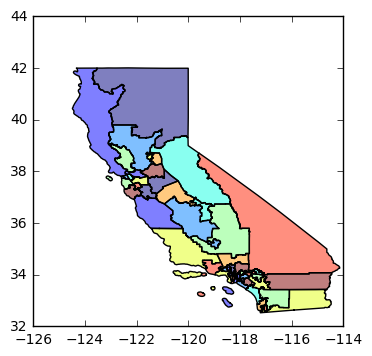

In [56]:
df.dissolve(by='Congressional District').plot()